## use InceptionV3 for feature extraction

In [ ]:
# 定义InvecptionV3的预处理模型
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
import numpy as np

base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x) # add a global spatial average pooling layer
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
# 对每张照片预处理并存储在lmdb里
import lmdb

batch_size = 128
img_path = "../data/img/"

imgid_set = set(map(lambda x: x[0], train_list) + \
            map(lambda x: x[2], train_list) + \
            map(lambda x: x[0], valid_list) + \
            map(lambda x: x[2], valid_list))
env = lmdb.open("./data/features", map_size=8192*3*len(imgid_set))

def preprocess(imgid):
    try:
        filename = img_path+"%s.jpg"%imgid
        img = image.load_img(filename, target_size=(299, 299))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        return x
    except Exception, e:
        print str(e)
        return None

imgids = []
X = []
for i, imgid in enumerate(imgid_set):
    x = preprocess(imgid)
    if x is None:
        continue
    imgids.append(imgid)
    X.append(x)
    if len(X) == batch_size:
        features = model.predict_on_batch(np.array(X))
        
        txn = env.begin(write=True)
        for _imgid, _feature in zip(imgids, features):
            str_feature = _feature.tostring()
            txn.put(_imgid, str_feature)
        txn.commit()
        
        imgids = []
        X = []
        print "%d/%d"%(i, len(imgid_set))
        
if len(X) > 0:
    features = model.predict_on_batch(np.array(X))
    txn = env.begin(write=True)
    for _imgid, _feature in zip(imgids, features):
        str_feature = _feature.tostring()
        txn.put(_imgid, str_feature)
    txn.commit()

env.close()

## use mobilenet for feature extraction

In [ ]:
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
import numpy as np

base_model = MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='avg')
base_model.summary()

In [ ]:
import lmdb
import os
import cPickle as pickle
from tqdm import tqdm

batch_size = 128
img_path = "../data/img/"

env = lmdb.open("./data/mobilenet_feature", map_size=8192*4*100000)
ALL_IMGIDS = set()

def img_preprocess(imgfile):
    try:
        filename = img_path+imgfile
        img = image.load_img(filename, target_size=(224, 224))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        return x
    except Exception, e:
        return None
    
def img_preprocess_V2(imgfile):
    """split img into left, mid, right, and full"""
    def array_resize(x, target_size=(224, 224)):
        img = image.array_to_img(x)
        img = img.resize(target_size)
        return image.img_to_array(img)
    
    try:
        filename = img_path+imgfile
        img = image.load_img(filename)
        full_array = image.img_to_array(img)
        x, y, _ = full_array.shape
        loc_left = full_array[:, :int(y/3)]
        loc_mid = full_array[:, int(y/3):int(2*y/3)]
        loc_right = full_array[:, int(2*y/3):]
        x = map(array_resize, [full_array, loc_left, loc_mid, loc_right])
        x = map(preprocess_input, x)
        return x
    except Exception, e:
        return None
    
def save_to_lmdb(imgids, features):
    txn = env.begin(write=True)
    for _imgid, _feature in zip(imgids, features):
        str_feature = _feature.tostring()
        txn.put(_imgid, str_feature)
    txn.commit()
    
def save_to_lmdb_V2(imgids, features):
    """concat 4 features for each image"""
    txn = env.begin(write=True)
    for i in range(0, len(features), 4):
        _feature = np.concatenate(features[i:i+4])
        str_feature = _feature.tostring()
        _imgid = imgids[i//4]
        txn.put(_imgid, str_feature)
    txn.commit()

batch_imgids = []
batch_X = []
for imgfile in tqdm(os.listdir(img_path)):
    x = img_preprocess_V2(imgfile)
    if x is None:
        continue
    batch_X.extend(x)
    batch_imgids.append(os.path.splitext(imgfile)[0])
    ALL_IMGIDS.add(os.path.splitext(imgfile)[0])
    if len(batch_X) == batch_size:
        batch_features = base_model.predict_on_batch(np.array(batch_X))
        save_to_lmdb_V2(batch_imgids, batch_features)
        batch_imgids = []
        batch_X = []
        
if len(batch_X) > 0:
    batch_features = base_model.predict_on_batch(np.array(batch_X))
    save_to_lmdb_V2(batch_imgids, batch_features)

env.close()

pickle.dump(ALL_IMGIDS, open("./data/ALL_IMGIDS.pick", 'wb'))

## use Fisher-Vector for generic feature

In [ ]:
from fisher import *

# train GMM
gmm = Gmm(K=10)
gmm.generate("../data/img/", img_size=(256, 256), limit=100)

In [ ]:
from fisher import *

gmm = Gmm(K=2)
gmm.load()
print gmm.weights
# train FishVectors
fisher_vector = FisherVector(gmm)

v = fisher_vector.fisher_vector_of_file("../data/img/989.jpg")

## Sample the training and validation dataset

In [11]:
# 计算并存储每张图片的score
import numpy as np
import cPickle as pickle

ALL_IMGIDS = pickle.load(open("./data/ALL_IMGIDS.pick", 'rb'))

def get_score(zan_num, cai_num, clk_num, hotness):
    return hotness
    zan_num = max(zan_num - 1, 0)
    return zan_num - cai_num + np.round(np.log(clk_num+1))

def get_date(date):
    return date[:8]

img_score_by_date = {}
X=[]
Y=[]
with open("../data/img_attr.csv", 'r') as fin:
    for line in fin:
        fields = line.strip().split("\t")
        if len(fields) != 7:
            continue
        imgid = fields[0]
        zan_num = int(fields[1])
        cai_num = int(fields[2])
        clk_num = int(fields[3])
        hotness = float(fields[4])
        X.append(clk_num)
        Y.append(hotness)
        score = get_score(zan_num, cai_num, clk_num, hotness)
        date = get_date(fields[5])
        if imgid in ALL_IMGIDS and date >= "2015/01" and date < "2017/01":
            img_score_by_date.setdefault(date, [])
            img_score_by_date[date].append((imgid, score))

print "#count of images: %d"%sum(map(len, img_score_by_date.values()))
print "#count of keys: %d"%len(img_score_by_date.keys())

#count of images: 83526
#count of keys: 24


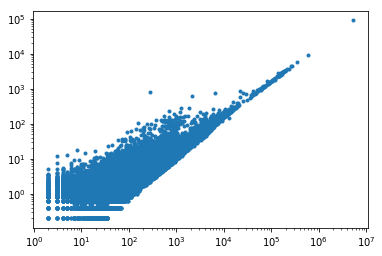

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.loglog(X, Y, '.')

In [15]:
# 构造用于模型训练和验证的pair数据对
import random
import os

def split_dataset(dataset, p):
    """
    return train_dataset, valid_dataset
    """
    random.shuffle(dataset)
    valid_size = int(len(dataset)*p)
    return dataset[:-valid_size], dataset[-valid_size:]

train_list = []
valid_list = []
p = 0.1 # valid_data ratio
k = 10 # compare with k images for each train image
delta = 5 # if abs(sa-sb) < delta, then abort this comparation pair
for date, imgs in img_score_by_date.items():
    train_imgs, valid_imgs = split_dataset(imgs, p)
    cmp_k = len(train_imgs) > k and k or len(train_imgs)
    
    for img_a, s_a in train_imgs:
        for img_b, s_b in random.sample(train_imgs, cmp_k):
            if abs(s_a-s_b) < delta:
                continue
            cmp_ret = s_a > s_b and 1 or 0
            train_list.append((img_a, s_a, img_b, s_b, cmp_ret))
            
    for img_a, s_a in valid_imgs:
        img_b, s_b = random.choice(valid_imgs)
        if abs(s_a-s_b) < 5:
            continue
        cmp_ret = s_a > s_b and 1 or 0
        valid_list.append((img_a, s_a, img_b, s_b, cmp_ret))
            
print "Length of Train List: %d"%len(train_list)
print "Length of Valid List: %d"%len(valid_list)

pickle.dump(train_list, open("./data/train_list.pick", 'wb'))
pickle.dump(valid_list, open("./data/valid_list.pick", 'wb'))

Length of Train List: 444653
Length of Valid List: 4923
